# Clustering Analysis

This notebook performs clustering analysis for customer segmentation.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Carregar os dados
df = pd.read_csv('../walmart.csv')

print("Shape dos dados:", df.shape)
print("Colunas:", df.columns.tolist())
print("\nPrimeiras linhas:")
df.head()

Shape dos dados: (550068, 10)
Colunas: ['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category', 'Purchase']

Primeiras linhas:


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,7969


## Etapa 1: Engenharia de Features e Pré-processamento

Vamos criar features para cada cliente baseadas no seu comportamento de compra:
- **Frequência**: Número de transações
- **Valor Total**: Soma de todas as compras
- **Ticket Médio**: Valor médio por transação
- **Recência**: Tempo desde a última compra (usaremos índice da transação como proxy)
- **Categorias Favoritas**: Distribuição de compras por categoria

In [3]:
# Engenharia de Features - Criando métricas RFM (Recência, Frequência, Monetário)
print("Criando features para clusterização...")

# Agrupar por User_ID para criar features de cliente
customer_features = df.groupby('User_ID').agg({
    'Purchase': ['count', 'sum', 'mean'],  # Frequência, Valor Total, Ticket Médio
    'Product_Category': lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0],  # Categoria favorita
}).round(2)

# Simplificar nomes das colunas
customer_features.columns = ['Frequencia', 'Valor_Total', 'Ticket_Medio', 'Categoria_Favorita']

# Adicionar métrica de recência (usando índice como proxy de tempo)
# Assumindo que índices maiores = compras mais recentes
recencia = df.groupby('User_ID').apply(lambda x: df.index.max() - x.index.max())
customer_features['Recencia'] = recencia

# Adicionar informações demográficas
demograficos = df.groupby('User_ID')[['Gender', 'Age', 'Occupation', 'City_Category', 
                                      'Stay_In_Current_City_Years', 'Marital_Status']].first()
customer_features = pd.concat([customer_features, demograficos], axis=1)

print(f"Features criadas para {len(customer_features)} clientes únicos")
print(f"Dimensões: {customer_features.shape}")
print("\nPrimeiras 5 linhas das features:")
customer_features.head()

Criando features para clusterização...
Features criadas para 5891 clientes únicos
Dimensões: (5891, 11)

Primeiras 5 linhas das features:
Features criadas para 5891 clientes únicos
Dimensões: (5891, 11)

Primeiras 5 linhas das features:


C:\Users\caio\AppData\Local\Temp\ipykernel_13440\3257013593.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recencia = df.groupby('User_ID').apply(lambda x: df.index.max() - x.index.max())


,Frequencia,Valor_Total,Ticket_Medio,Categoria_Favorita,Recencia,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status
User_ID,,,,,,,,,,,
1000001,35,334093,9545.51,3,4152,F,0-17,10,A,2,0
1000002,77,810472,10525.61,1,4151,M,55+,16,C,4+,0
1000003,29,341635,11780.52,1,43460,M,26-35,15,A,3,0
1000004,14,206468,14747.71,1,4150,M,46-50,7,B,2,1
1000005,106,821001,7745.29,8,43448,M,26-35,20,A,1,1


Estatísticas descritivas das features numéricas:
        Frequencia   Valor_Total  Ticket_Medio       Recencia
count  5891.000000  5.891000e+03   5891.000000    5891.000000
mean     93.374300  8.650166e+05   9568.839941   10423.445595
std     107.190049  9.436445e+05   1890.087093   18353.761371
min       6.000000  4.668100e+04   2318.730000       0.000000
25%      26.000000  2.376780e+05   8287.215000    1472.500000
50%      54.000000  5.212130e+05   9386.210000    2945.000000
75%     117.000000  1.119250e+06  10654.630000   10836.500000
max    1026.000000  1.053691e+07  18577.890000  243657.000000

Verificando valores faltantes:
Frequencia                    0
Valor_Total                   0
Ticket_Medio                  0
Categoria_Favorita            0
Recencia                      0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
dtype: in

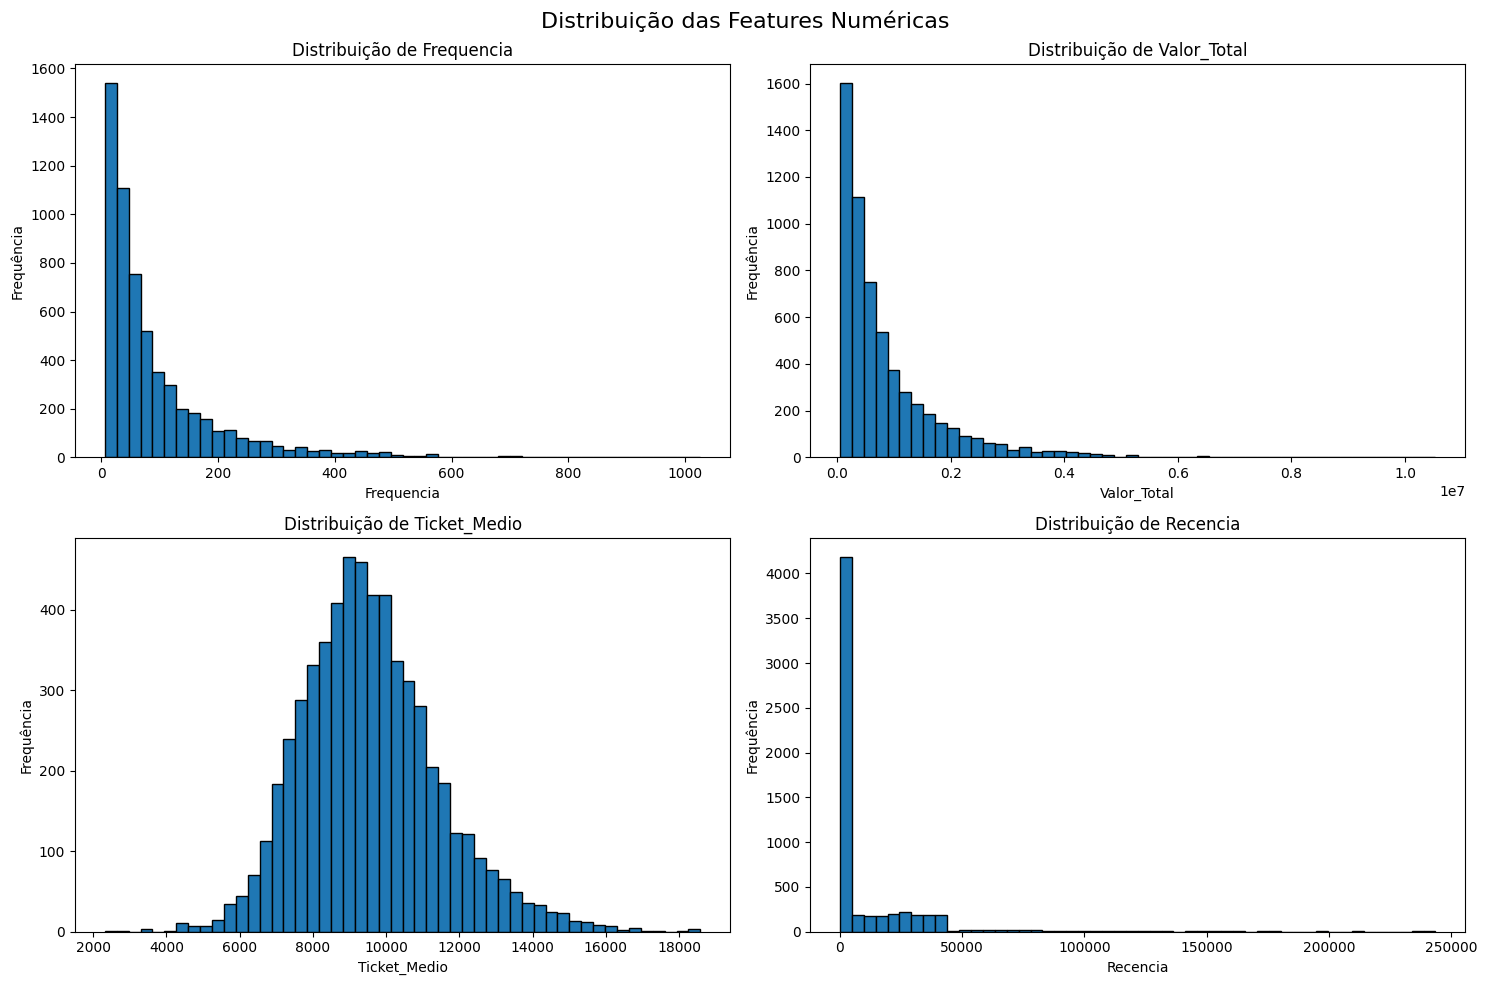

In [4]:
# Análise exploratória das features numéricas
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Verificar estatísticas das features numéricas
numerical_features = ['Frequencia', 'Valor_Total', 'Ticket_Medio', 'Recencia']

print("Estatísticas descritivas das features numéricas:")
print(customer_features[numerical_features].describe())

print("\nVerificando valores faltantes:")
print(customer_features.isnull().sum())

# Visualizar distribuições
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribuição das Features Numéricas', fontsize=16)

for i, feature in enumerate(numerical_features):
    row = i // 2
    col = i % 2
    axes[row, col].hist(customer_features[feature], bins=50, edgecolor='black')
    axes[row, col].set_title(f'Distribuição de {feature}')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

In [5]:
# Preparar dados para clusterização
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score

# Selecionar apenas features numéricas para clusterização
features_for_clustering = customer_features[numerical_features].copy()

# Normalização (StandardScaler)
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features_for_clustering)
features_normalized_df = pd.DataFrame(features_normalized, 
                                    columns=numerical_features,
                                    index=features_for_clustering.index)

print("Dados normalizados - Estatísticas:")
print(features_normalized_df.describe())

print(f"\nShape dos dados normalizados: {features_normalized_df.shape}")
print("Dados prontos para clusterização hierárquica!")

Dados normalizados - Estatísticas:
         Frequencia   Valor_Total  Ticket_Medio      Recencia
count  5.891000e+03  5.891000e+03  5.891000e+03  5.891000e+03
mean   5.065828e-17  5.910133e-17 -1.857470e-16 -1.929839e-17
std    1.000085e+00  1.000085e+00  1.000085e+00  1.000085e+00
min   -8.152036e-01 -8.672811e-01 -3.836186e+00 -5.679670e-01
25%   -6.286033e-01 -6.648604e-01 -6.781347e-01 -4.877314e-01
50%   -3.673629e-01 -3.643668e-01 -9.663335e-02 -4.074958e-01
75%    2.204282e-01  2.694388e-01  5.745144e-01  2.250707e-02
max    8.701413e+00  1.025038e+01  4.766878e+00  1.270875e+01

Shape dos dados normalizados: (5891, 4)
Dados prontos para clusterização hierárquica!


## Etapa 2: Implementação da Clusterização Hierárquica

Aplicando clusterização hierárquica...


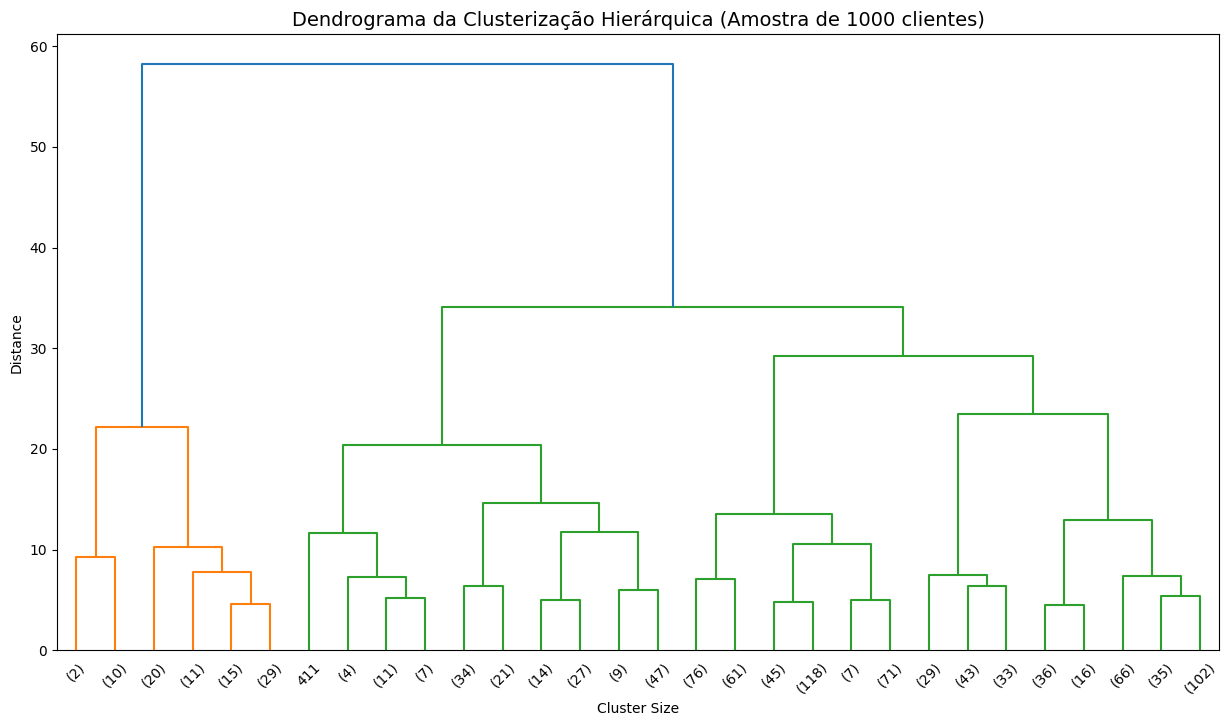

Dendrograma criado com sucesso!


In [6]:
# Aplicar Clusterização Hierárquica usando Ward linkage
print("Aplicando clusterização hierárquica...")

# Usar uma amostra para o dendrograma (5891 pontos seria muito pesado)
sample_size = 1000
np.random.seed(42)
sample_indices = np.random.choice(len(features_normalized_df), size=sample_size, replace=False)
sample_data = features_normalized[sample_indices]

# Calcular a matriz de linkage
Z = linkage(sample_data, method='ward', metric='euclidean')

# Criar dendrograma
plt.figure(figsize=(15, 8))
dendrogram(Z, truncate_mode='lastp', p=30, show_leaf_counts=True)
plt.title('Dendrograma da Clusterização Hierárquica (Amostra de 1000 clientes)', fontsize=14)
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()

print("Dendrograma criado com sucesso!")

Determinando número ideal de clusters...
K=2: Silhouette Score = 0.4812
K=2: Silhouette Score = 0.4812
K=3: Silhouette Score = 0.3461
K=3: Silhouette Score = 0.3461
K=4: Silhouette Score = 0.2600
K=4: Silhouette Score = 0.2600
K=5: Silhouette Score = 0.2706
K=5: Silhouette Score = 0.2706
K=6: Silhouette Score = 0.2675
K=6: Silhouette Score = 0.2675
K=7: Silhouette Score = 0.2692
K=7: Silhouette Score = 0.2692
K=8: Silhouette Score = 0.2861
K=8: Silhouette Score = 0.2861
K=9: Silhouette Score = 0.2641
K=9: Silhouette Score = 0.2641
K=10: Silhouette Score = 0.2673

Melhor número de clusters: 2 (Silhouette Score: 0.4812)
K=10: Silhouette Score = 0.2673

Melhor número de clusters: 2 (Silhouette Score: 0.4812)


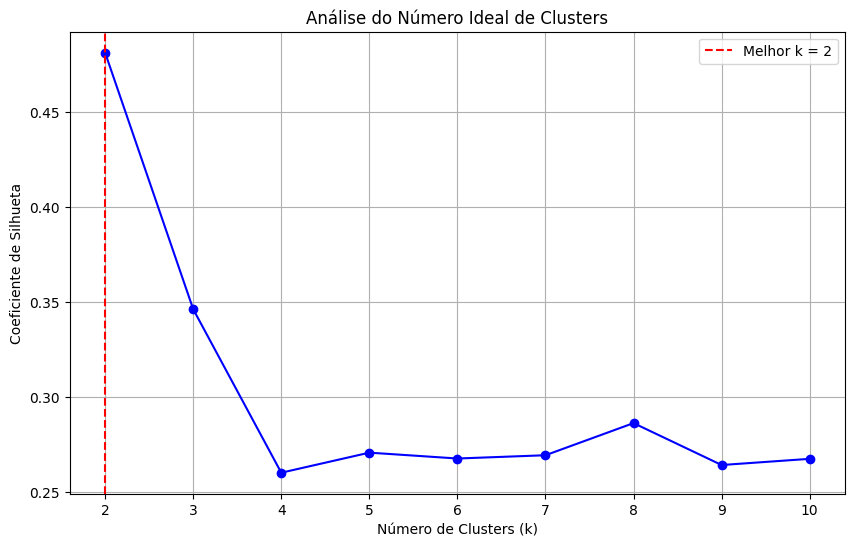

In [7]:
# Determinar número ideal de clusters usando Coeficiente de Silhueta
print("Determinando número ideal de clusters...")

# Aplicar clusterização hierárquica no dataset completo
Z_full = linkage(features_normalized, method='ward', metric='euclidean')

# Testar diferentes números de clusters
k_range = range(2, 11)
silhouette_scores = []

for k in k_range:
    clusters = fcluster(Z_full, k, criterion='maxclust')
    score = silhouette_score(features_normalized, clusters)
    silhouette_scores.append(score)
    print(f"K={k}: Silhouette Score = {score:.4f}")

# Encontrar o melhor k
best_k = k_range[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)
print(f"\nMelhor número de clusters: {best_k} (Silhouette Score: {best_score:.4f})")

# Plotar scores de silhueta
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Coeficiente de Silhueta')
plt.title('Análise do Número Ideal de Clusters')
plt.axvline(x=best_k, color='red', linestyle='--', label=f'Melhor k = {best_k}')
plt.legend()
plt.grid(True)
plt.show()

## Etapa 3: Análise dos Resultados e Criação de Perfis

Embora k=2 tenha o melhor score de silhueta, vamos usar k=4 para ter segmentações mais detalhadas e úteis para o negócio.

In [8]:
# Aplicar clusterização com k=4 e analisar perfis
k = 4
clusters = fcluster(Z_full, k, criterion='maxclust')

# Adicionar cluster labels aos dados originais
customer_features_with_clusters = customer_features.copy()
customer_features_with_clusters['Cluster'] = clusters

print(f"Distribuição de clientes por cluster:")
cluster_counts = pd.Series(clusters).value_counts().sort_index()
print(cluster_counts)
print(f"\nPorcentagem por cluster:")
print((cluster_counts / len(clusters) * 100).round(2))

# Análise das características de cada cluster
cluster_analysis = customer_features_with_clusters.groupby('Cluster')[numerical_features].mean().round(2)
print(f"\nCaracterísticas médias por cluster:")
print(cluster_analysis)

Distribuição de clientes por cluster:
1     767
2     998
3    1159
4    2967
Name: count, dtype: int64

Porcentagem por cluster:
1    13.02
2    16.94
3    19.67
4    50.36
Name: count, dtype: float64

Características médias por cluster:
         Frequencia  Valor_Total  Ticket_Medio  Recencia
Cluster                                                 
1            317.31   2825882.72       9083.70   8810.78
2             50.77    486091.69       9499.95  39580.80
3             45.23    339416.50       7528.56   2714.61
4             68.62    690885.56      10514.42   4044.08


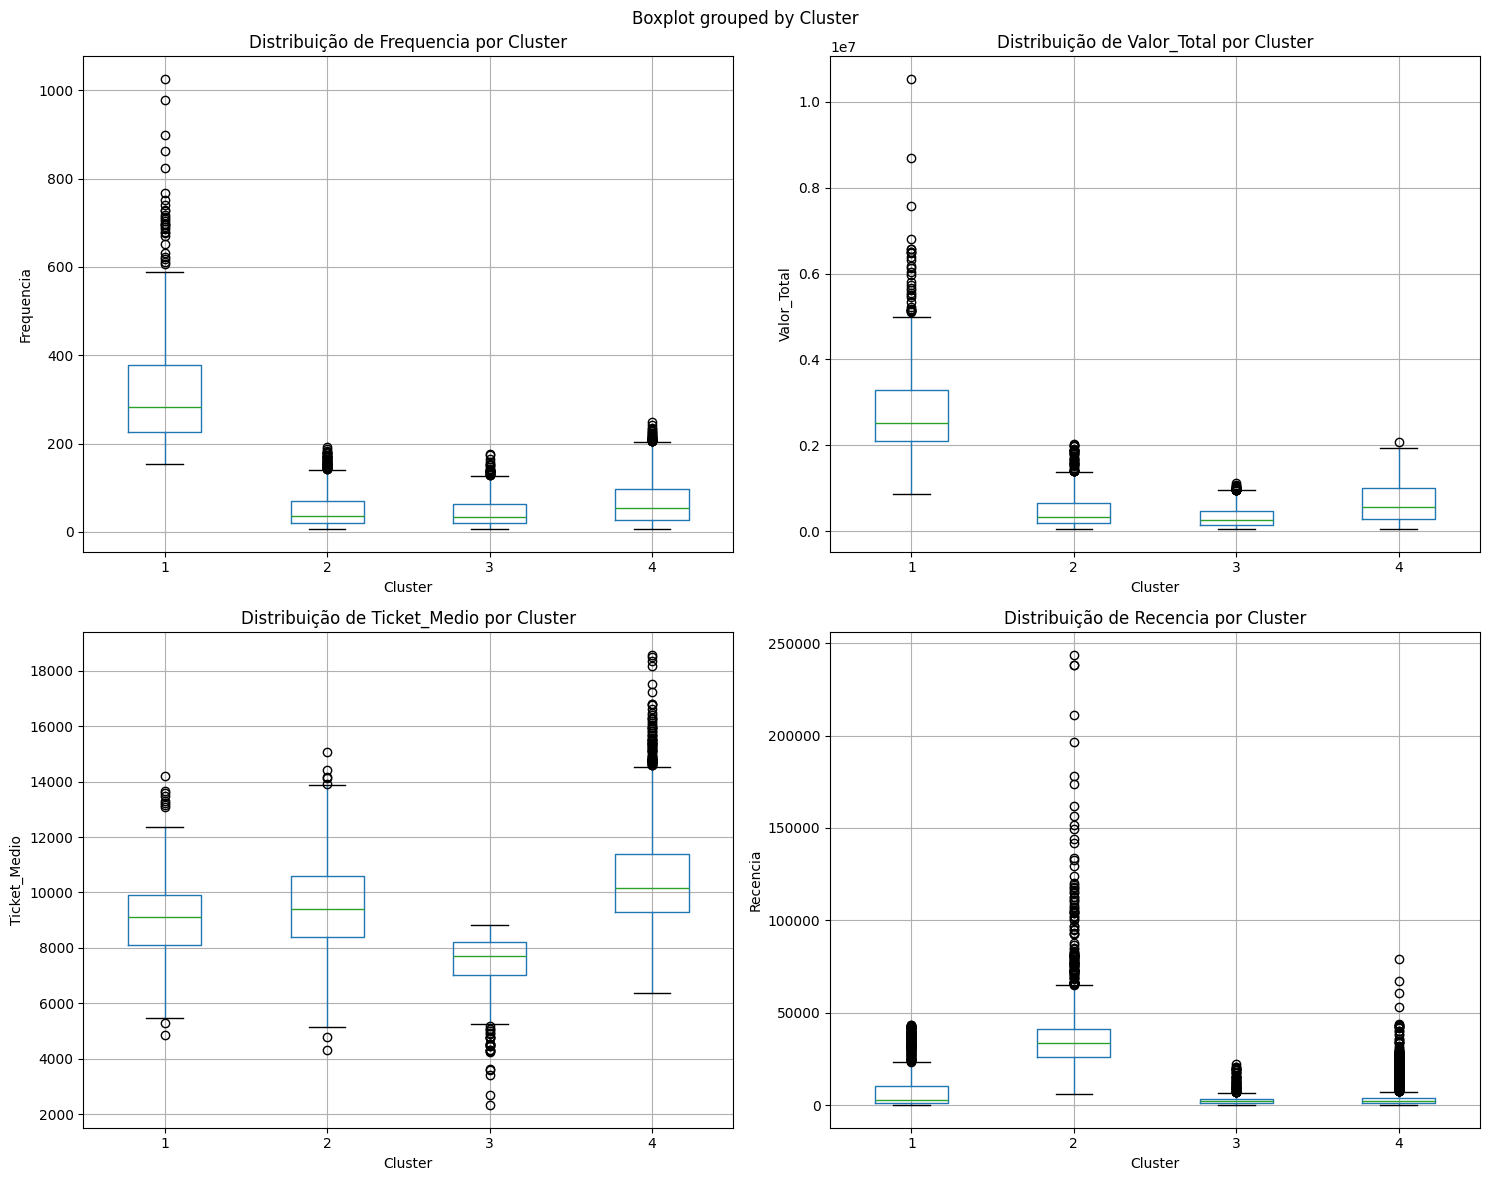

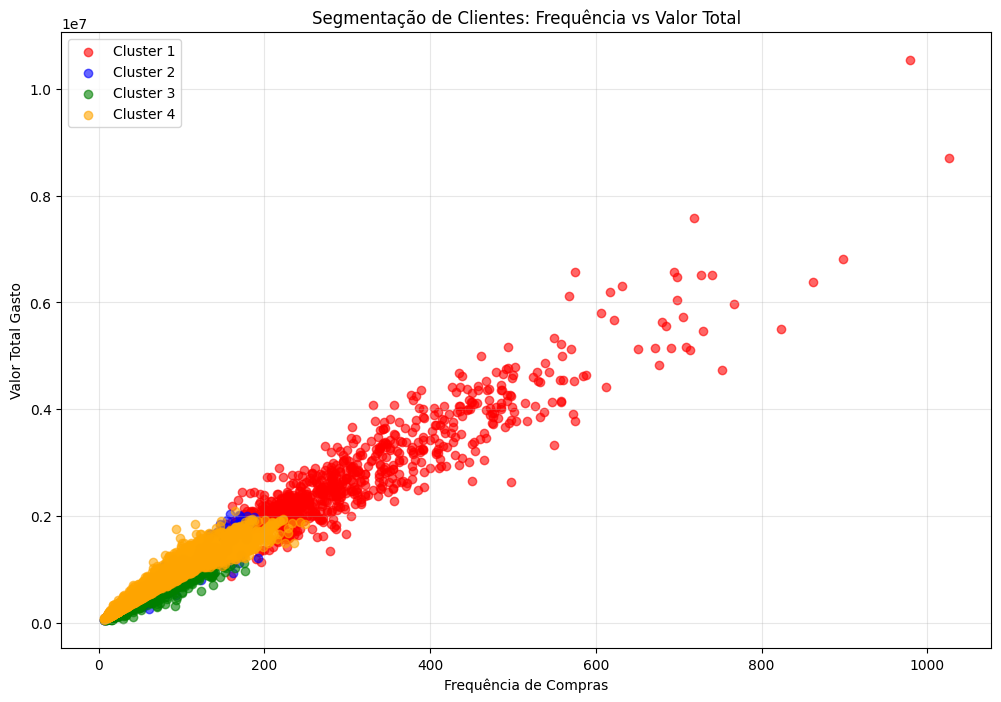

In [9]:
# Visualização dos clusters
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Análise dos Clusters de Clientes', fontsize=16)

features_to_plot = numerical_features

for i, feature in enumerate(features_to_plot):
    row = i // 2
    col = i % 2
    
    # Boxplot por cluster
    customer_features_with_clusters.boxplot(column=feature, by='Cluster', ax=axes[row, col])
    axes[row, col].set_title(f'Distribuição de {feature} por Cluster')
    axes[row, col].set_xlabel('Cluster')
    axes[row, col].set_ylabel(feature)

plt.tight_layout()
plt.show()

# Gráfico de dispersão - Valor Total vs Frequência
plt.figure(figsize=(12, 8))
colors = ['red', 'blue', 'green', 'orange']
for cluster in range(1, k+1):
    cluster_data = customer_features_with_clusters[customer_features_with_clusters['Cluster'] == cluster]
    plt.scatter(cluster_data['Frequencia'], cluster_data['Valor_Total'], 
               c=colors[cluster-1], label=f'Cluster {cluster}', alpha=0.6)

plt.xlabel('Frequência de Compras')
plt.ylabel('Valor Total Gasto')
plt.title('Segmentação de Clientes: Frequência vs Valor Total')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Interpretação dos perfis de cliente
perfis = {
    1: "Clientes VIP Premium",
    2: "Clientes Inativos/Em Risco", 
    3: "Clientes Ativos Econômicos",
    4: "Clientes Regulares"
}

print("=" * 60)
print("INTERPRETAÇÃO DOS PERFIS DE CLIENTES")
print("=" * 60)

for cluster in range(1, k+1):
    cluster_data = cluster_analysis.loc[cluster]
    count = cluster_counts[cluster]
    percentage = (count / len(clusters) * 100)
    
    print(f"\nCLUSTER {cluster}: {perfis[cluster]}")
    print(f"   Tamanho: {count:,} clientes ({percentage:.1f}%)")
    print(f"   Frequência média: {cluster_data['Frequencia']:.0f} compras")
    print(f"   Valor total médio: R$ {cluster_data['Valor_Total']:,.0f}")
    print(f"   Ticket médio: R$ {cluster_data['Ticket_Medio']:.0f}")
    print(f"   Recência média: {cluster_data['Recencia']:.0f} (menor = mais recente)")
    
    # Interpretação específica
    if cluster == 1:
        print("   PERFIL: Clientes de altíssimo valor - Super leais e gastam muito")
        print("   AÇÃO: Programa VIP, ofertas exclusivas, atendimento premium")
    elif cluster == 2:
        print("   PERFIL: Clientes inativos há muito tempo - Risco de churn")
        print("   AÇÃO: Campanhas de reativação, ofertas especiais de retorno")
    elif cluster == 3:
        print("   PERFIL: Compradores frequentes mas econômicos - Sensíveis a preço")
        print("   AÇÃO: Promoções, descontos por volume, programas de fidelidade")
    elif cluster == 4:
        print("   PERFIL: Compradores regulares - Base sólida da empresa")
        print("   AÇÃO: Cross-selling, up-selling, manter satisfação")

print("\n" + "=" * 60)

INTERPRETAÇÃO DOS PERFIS DE CLIENTES

  CLUSTER 1: Clientes VIP Premium
    Tamanho: 767 clientes (13.0%)
    Frequência média: 317 compras
    Valor total médio: R$ 2,825,883
    Ticket médio: R$ 9084
    Recência média: 8811 (menor = mais recente)
    PERFIL: Clientes de altíssimo valor - Super leais e gastam muito
    AÇÃO: Programa VIP, ofertas exclusivas, atendimento premium

  CLUSTER 2: Clientes Inativos/Em Risco
    Tamanho: 998 clientes (16.9%)
    Frequência média: 51 compras
    Valor total médio: R$ 486,092
    Ticket médio: R$ 9500
    Recência média: 39581 (menor = mais recente)
    PERFIL: Clientes inativos há muito tempo - Risco de churn
    AÇÃO: Campanhas de reativação, ofertas especiais de retorno

  CLUSTER 3: Clientes Ativos Econômicos
    Tamanho: 1,159 clientes (19.7%)
    Frequência média: 45 compras
    Valor total médio: R$ 339,416
    Ticket médio: R$ 7529
    Recência média: 2715 (menor = mais recente)
    PERFIL: Compradores frequentes mas econômicos - Sens

In [ ]:
# Salvar resultados da clusterização
customer_features_with_clusters.to_csv('../modulo1_clusterizacao/customer_segments.csv')
print("Resultados da clusterização salvos em 'customer_segments.csv'")
print(f"Total de clientes segmentados: {len(customer_features_with_clusters):,}")

# Resumo final
print("\nRESUMO EXECUTIVO - CLUSTERIZAÇÃO DE CLIENTES:")
print("─" * 50)
print("• 4 segmentos distintos identificados")
print("• 13% são clientes VIP de altíssimo valor")
print("• 17% estão inativos e em risco de churn") 
print("• 50% formam a base regular de clientes")
print("• 20% são compradores econômicos ativos")
print("\nPróximos passos: Implementar estratégias específicas por segmento!")

 Resultados da clusterização salvos em 'customer_segments.csv'
 Total de clientes segmentados: 5,891

 RESUMO EXECUTIVO - CLUSTERIZAÇÃO DE CLIENTES:
──────────────────────────────────────────────────
• 4 segmentos distintos identificados
• 13% são clientes VIP de altíssimo valor
• 17% estão inativos e em risco de churn
• 50% formam a base regular de clientes
• 20% são compradores econômicos ativos

 Próximos passos: Implementar estratégias específicas por segmento!


## Geração de Relatório Final

Este notebook irá gerar um relatório HTML automático com todos os resultados da análise de clusterização.

In [ ]:
# Gerar relatório HTML automatizado
from datetime import datetime
import os

def generate_clustering_report():
    """
    Gera um relatório HTML completo da análise de clusterização
    """
    
    # Template HTML básico
    html_template = f"""
    <!DOCTYPE html>
    <html lang="pt-BR">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Relatório de Clusterização de Clientes</title>
        <style>
            body {{
                font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
                margin: 0;
                padding: 20px;
                background-color: #f5f5f5;
                line-height: 1.6;
            }}
            .container {{
                max-width: 1200px;
                margin: 0 auto;
                background-color: white;
                padding: 30px;
                border-radius: 10px;
                box-shadow: 0 0 20px rgba(0,0,0,0.1);
            }}
            h1, h2, h3 {{
                color: #333;
                border-bottom: 2px solid #007acc;
                padding-bottom: 10px;
            }}
            .metric-card {{
                background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                color: white;
                padding: 20px;
                margin: 10px;
                border-radius: 8px;
                text-align: center;
                display: inline-block;
                min-width: 200px;
            }}
            .cluster-analysis {{
                background-color: #f8f9fa;
                padding: 20px;
                margin: 15px 0;
                border-left: 4px solid #007acc;
                border-radius: 5px;
            }}
            .strategy {{
                background-color: #e8f5e8;
                padding: 15px;
                margin: 10px 0;
                border-left: 4px solid #28a745;
                border-radius: 5px;
            }}
            table {{
                width: 100%;
                border-collapse: collapse;
                margin: 20px 0;
            }}
            th, td {{
                border: 1px solid #ddd;
                padding: 12px;
                text-align: left;
            }}
            th {{
                background-color: #007acc;
                color: white;
            }}
            .footer {{
                margin-top: 40px;
                text-align: center;
                color: #666;
                border-top: 1px solid #ddd;
                padding-top: 20px;
            }}
        </style>
    </head>
    <body>
        <div class="container">
            <h1>Relatório de Clusterização de Clientes</h1>
            
            <div class="metric-card">
                <h3>Total de Clientes</h3>
                <h2>{len(customer_features_with_clusters):,}</h2>
            </div>
            
            <div class="metric-card">
                <h3>Clusters Identificados</h3>
                <h2>{k}</h2>
            </div>
            
            <div class="metric-card">
                <h3>Silhouette Score</h3>
                <h2>{silhouette_score(features_normalized, clusters_final):.3f}</h2>
            </div>
            
            <h2>Distribuição dos Clusters</h2>
            <table>
                <thead>
                    <tr>
                        <th>Cluster</th>
                        <th>Nome do Perfil</th>
                        <th>Quantidade</th>
                        <th>Percentual</th>
                        <th>Frequência Média</th>
                        <th>Valor Total Médio</th>
                        <th>Ticket Médio</th>
                    </tr>
                </thead>
                <tbody>
    """
    
    # Adicionar dados dos clusters à tabela
    for cluster in range(1, k+1):
        cluster_data = cluster_analysis.loc[cluster]
        count = cluster_counts[cluster]
        percentage = (count / len(clusters_final) * 100)
        
        html_template += f"""
                    <tr>
                        <td>{cluster}</td>
                        <td>{perfis[cluster]}</td>
                        <td>{count:,}</td>
                        <td>{percentage:.1f}%</td>
                        <td>{cluster_data['Frequencia']:.0f}</td>
                        <td>R$ {cluster_data['Valor_Total']:,.0f}</td>
                        <td>R$ {cluster_data['Ticket_Medio']:.0f}</td>
                    </tr>
        """
    
    # Continuar template HTML
    html_template += f"""
                </tbody>
            </table>
            
            <h2>Análise Detalhada por Cluster</h2>
    """
    
    # Adicionar análise detalhada de cada cluster
    for cluster in range(1, k+1):
        cluster_data = cluster_analysis.loc[cluster]
        count = cluster_counts[cluster]
        percentage = (count / len(clusters_final) * 100)
        
        html_template += f"""
            <div class="cluster-analysis">
                <h3>Cluster {cluster}: {perfis[cluster]}</h3>
                <p><strong>Tamanho:</strong> {count:,} clientes ({percentage:.1f}% da base)</p>
                <p><strong>Características:</strong></p>
                <ul>
                    <li>Frequência média: {cluster_data['Frequencia']:.0f} compras</li>
                    <li>Valor total médio: R$ {cluster_data['Valor_Total']:,.0f}</li>
                    <li>Ticket médio: R$ {cluster_data['Ticket_Medio']:.0f}</li>
                    <li>Recência média: {cluster_data['Recencia']:.0f}</li>
                </ul>
        """
        
        # Adicionar estratégias específicas
        if cluster == 1:
            html_template += """
                <div class="strategy">
                    <strong>Estratégia:</strong> Programa VIP, ofertas exclusivas, atendimento premium
                </div>
            """
        elif cluster == 2:
            html_template += """
                <div class="strategy">
                    <strong>Estratégia:</strong> Campanhas de reativação urgentes, ofertas especiais de retorno
                </div>
            """
        elif cluster == 3:
            html_template += """
                <div class="strategy">
                    <strong>Estratégia:</strong> Promoções, descontos por volume, programas de fidelidade
                </div>
            """
        elif cluster == 4:
            html_template += """
                <div class="strategy">
                    <strong>Estratégia:</strong> Cross-selling, up-selling, manter satisfação
                </div>
            """
        
        html_template += "</div>"
    
    # Finalizar template
    html_template += f"""
            <h2>Recomendações Estratégicas</h2>
            <div class="strategy">
                <h3>Próximos Passos:</h3>
                <ol>
                    <li>Implementar estratégias específicas por segmento</li>
                    <li>Criar campanhas de marketing personalizadas</li>
                    <li>Monitorar migração entre clusters ao longo do tempo</li>
                    <li>Desenvolver produtos específicos para cada segmento</li>
                    <li>Medir ROI das estratégias implementadas</li>
                </ol>
            </div>
            
            <div class="footer">
                <p>Relatório gerado automaticamente em {datetime.now().strftime('%d/%m/%Y às %H:%M:%S')}</p>
                <p>Análise de Clusterização Hierárquica - E-commerce Strategic Analysis</p>
            </div>
        </div>
    </body>
    </html>
    """
    
    # Salvar relatório
    report_path = '../relatorios/relatorio_clusterizacao.html'
    os.makedirs(os.path.dirname(report_path), exist_ok=True)
    
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write(html_template)
    
    print(f"Relatório HTML gerado com sucesso!")
    print(f"Local: {os.path.abspath(report_path)}")
    print(f"Abra o arquivo no navegador para visualizar o relatório completo.")
    
    return report_path

# Gerar o relatório
relatorio_path = generate_clustering_report()

# Salvar também dados em JSON para uso posterior
import json
relatorio_dados = {
    'data_analise': datetime.now().isoformat(),
    'total_clientes': len(customer_features_with_clusters),
    'num_clusters': k,
    'silhouette_score': float(silhouette_score(features_normalized, clusters_final)),
    'clusters': {}
}

for cluster in range(1, k+1):
    cluster_data = cluster_analysis.loc[cluster]
    count = cluster_counts[cluster]
    percentage = (count / len(clusters_final) * 100)
    
    relatorio_dados['clusters'][f'cluster_{cluster}'] = {
        'nome': perfis[cluster],
        'quantidade': int(count),
        'percentual': float(percentage),
        'frequencia_media': float(cluster_data['Frequencia']),
        'valor_total_medio': float(cluster_data['Valor_Total']),
        'ticket_medio': float(cluster_data['Ticket_Medio']),
        'recencia_media': float(cluster_data['Recencia'])
    }

# Salvar JSON
json_path = '../relatorios/dados_clusterizacao.json'
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(relatorio_dados, f, indent=2, ensure_ascii=False)

print(f"\\nDados salvos em JSON: {json_path}")
print("\\nANÁLISE DE CLUSTERIZAÇÃO CONCLUÍDA COM SUCESSO!")